# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 5 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = 1 #np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 1.1206361e-02-3.15683428e-03j -6.4771902e-03-1.69084296e-02j
  -1.2275677e-03-1.11372210e-02j  1.9714904e-03-6.31171465e-03j
  -6.5205863e-04+8.43718741e-03j]
 [ 3.1964611e-03-1.77578756e-03j  1.6269542e-01+4.13703384e+01j
   1.5050014e-03+8.26686528e-03j  2.3977261e-02+1.14738336e-02j
  -7.3466953e-03+9.21519566e-03j]
 [ 1.0150625e-02-3.20342509e-03j -3.7182984e-03+6.08249521e-03j
   2.0200418e-02+9.26561002e-03j -6.2760785e-03+1.24783665e-02j
  -1.5182613e-02+1.39195751e-02j]
 [-1.1679788e-02-1.34440651e-02j  2.1248206e-03-2.33970396e-02j
   5.1249542e+01+3.32813377e+01j  4.6655087e+01+6.91523438e+01j
   3.5545919e-03+1.12418644e-02j]
 [-1.0265710e-02+1.15797026e-02j  9.8361215e-04+2.23967922e-03j
  -2.4148781e-02-9.93605005e-04j  2.2522896e-04+1.01531502e-02j
  -9.0153757e-03-1.43618407e-02j]]


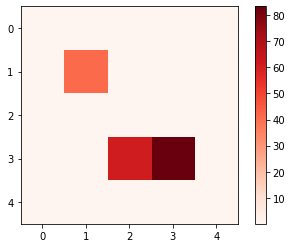

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[  98.05043 +143.82368j    -60.98735  -72.98633j
    88.5771    +2.4264278j  -28.258904  -6.0513163j
   -97.36823  -67.26247j  ]
 [ -99.96532  -12.789784j   155.61658  -23.19692j
   -97.69523  -24.739132j   -52.258484 -11.418291j
    94.32034  +72.08266j  ]
 [ 151.83104  -95.10479j   -136.83237  +35.61912j
    14.81903  -37.063084j    24.973875 +53.395332j
   -54.797253 +43.1365j   ]
 [ -91.54297  +91.3656j      11.055208-108.9379j
   -14.199031+113.68964j     12.29483  +17.318117j
    82.56217 -113.58086j  ]
 [ -58.349075-127.440094j    31.055246+169.58084j
     8.53261  -54.320415j    43.386242 -53.254227j
   -24.540314 +65.62878j  ]]


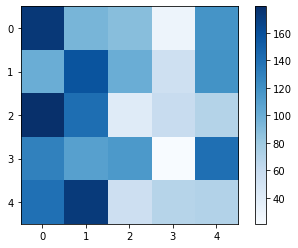

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [6]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.845784e-13
Imaginaries MSE: 1.622106e-13


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [10]:
print(math.ceil(math.log2(25)))

5


[[  98.05043 +143.82367j    -60.987347 -72.98632j
    88.577095  +2.4264278j  -28.258904  -6.051316j
   -97.36823  -67.26247j  ]
 [ -99.96532  -12.789784j   155.61658  -23.19692j
   -97.69523  -24.73913j    -52.25848  -11.41829j
    94.320335 +72.08265j  ]
 [ 151.83104  -95.10478j   -136.83237  +35.619118j
    14.819029 -37.063084j    24.973873 +53.39533j
   -54.79725  +43.136497j ]
 [ -91.54296  +91.3656j      11.055208-108.9379j
   -14.19903 +113.68964j     12.29483  +17.318117j
    82.56217 -113.58086j  ]
 [ -58.34907 -127.44009j     31.055246+169.58083j
     8.53261  -54.320415j    43.386242 -53.254227j
   -24.540312 +65.62878j  ]]


C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcpara

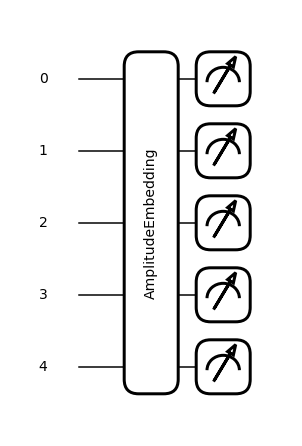

In [25]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.) 
    return qml.state()

readout = amp_encoding(normalized_data).astype('complex64')
qml.draw_mpl(amp_encoding)(normalized_data)
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = readout[readout.nonzero()]
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

## 4) Applying 2D IFT (fidelity test)

In [26]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 4.514387e-13
Imaginaries MSE: 1.160741e-12


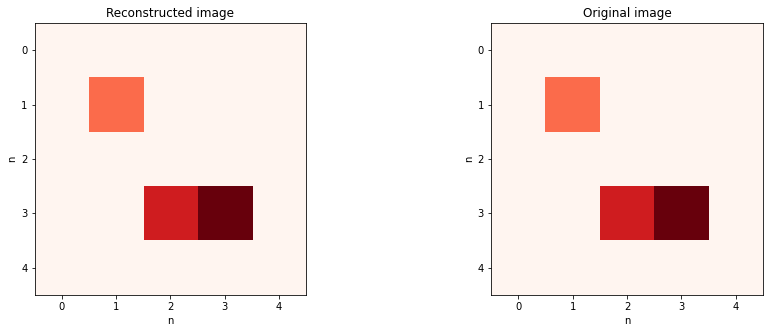

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')